# Taxi orders forecasting

The company 'Taxi 888' has collected historical data on cab orders at airports. To attract more drivers at peak times, you need to predict the number of cab orders for the next hour. Construct a model for this prediction.

The value of the *RMSE* metric on the test sample should not exceed 48.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Model-testing" data-toc-modified-id="Model-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model testing</a>

## Data preprocessing

Import the necessary libraries and modules for further work:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.model_selection import TimeSeriesSplit

In [2]:
try:
    data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Let's check the chronological consistency of the time series:

In [3]:
data.index.is_monotonic

True

Let's perform resampling one hour at a time. Let's output the first 5 lines of the dataframe:

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
print('Time interval data:', data.index.min(), '|', data.index.max())

Time interval data: 2018-03-01 00:00:00 | 2018-08-31 23:00:00


**Conclusion:** we imported the necessary libraries and modules, loaded the data and performed resampling one hour at a time, we also checked the chronological sequence of the time series using `is_monotonic`.

## Data analysis

Let's display the statistical data in the table:

In [6]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


It follows from the data that an average of 84 orders per hour, the maximum number of orders per hour - 462.

Let us decompose the data into three components: trend, seasonality, and residual. Let's plot the time series and analyze the data:

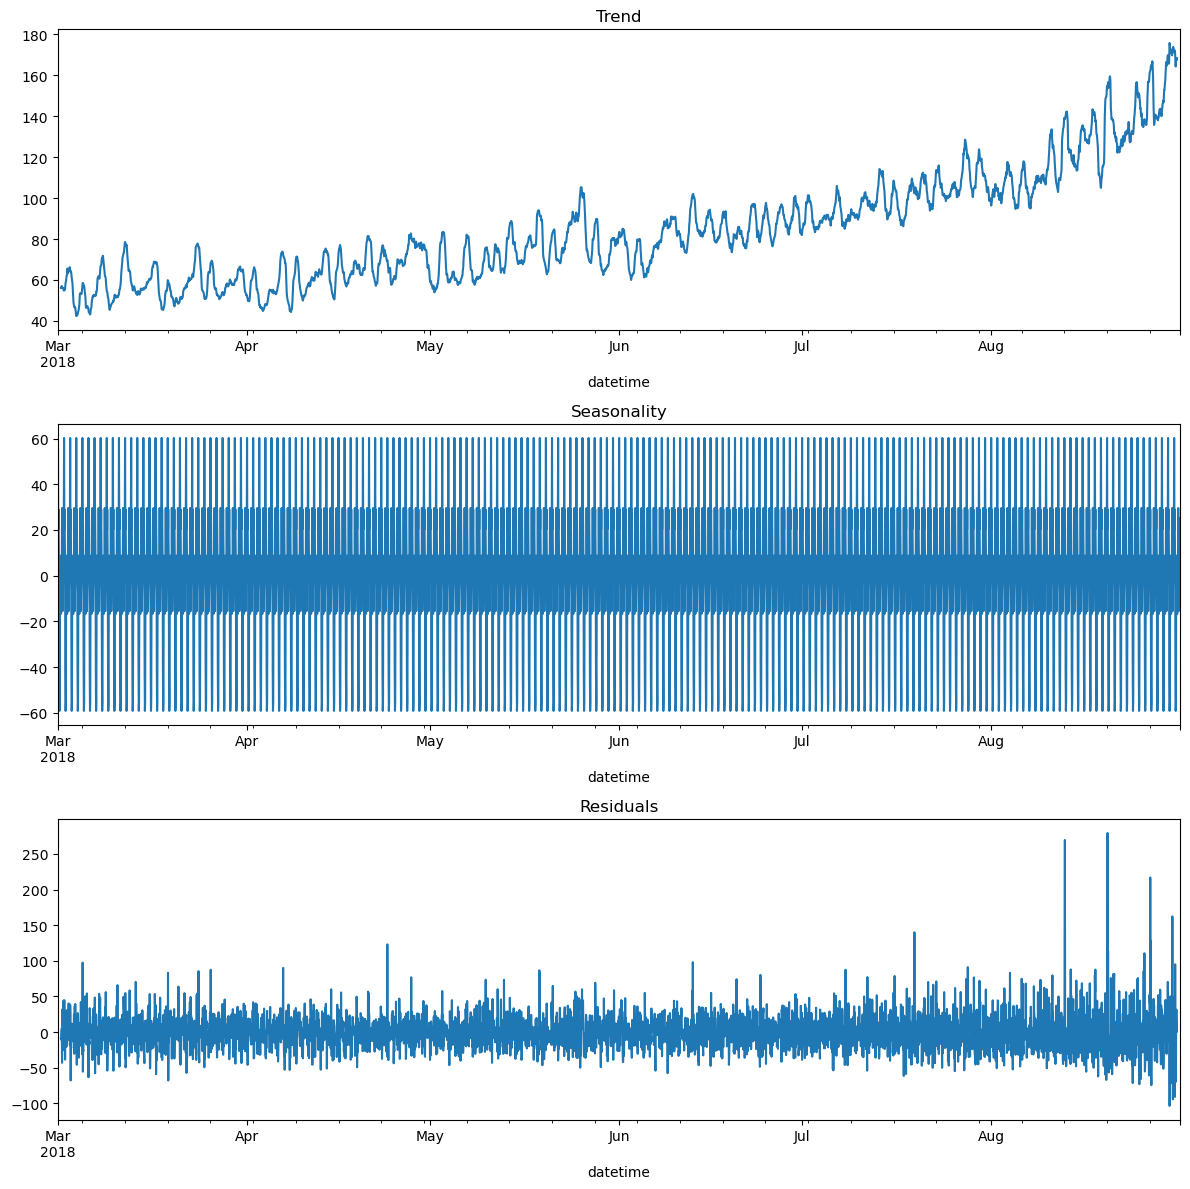

In [7]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

There is an increasing trend, but on this scale it is difficult to estimate the seasonal component. Let's consider a cross-section of the data for the last few days of August:

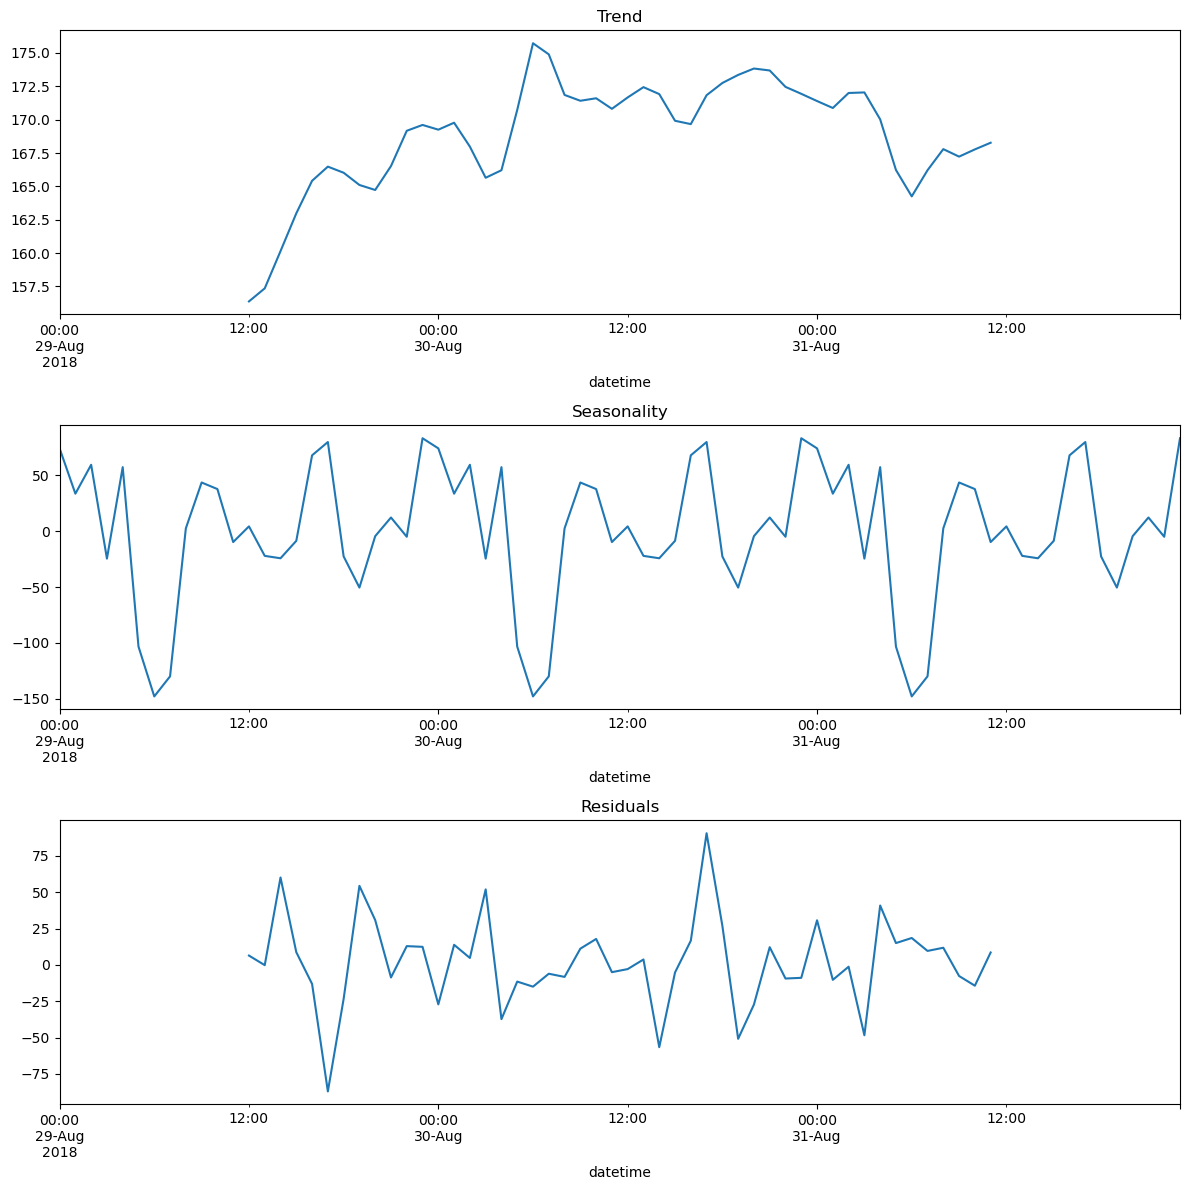

In [8]:
decomposed = seasonal_decompose(data['2018-08-29':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

The number of orders drops sharply from 12 a.m. to 6 a.m., increases in the morning hours, reaching its morning peak around 9-10 a.m. Then there is a slight decrease until 2 p.m., followed by an increase to the maximum around 5 or 6 p.m. Further, the number of orders decreases again until 8 p.m. and begins to grow in the evening hours, reaching a peak around 11 p.m. - 12 a.m. at night.

**Conclusion:** 
- We analyzed the statistical data and found that on average 84 orders are received per hour, the maximum number of orders per hour is 462
- we decomposed the data into three components: trend, seasonality and residual, and plotted a time series and found that there is an increasing trend, but on this scale it is difficult to evaluate the seasonal component
- We have additionally analyzed the data for the last days of August and came to the conclusion that the amount of orders sharply drops from 12 a.m. to 6 a.m., increases in the morning hours, reaching its morning peak around 9-10 a.m. Further there is some decrease till 14 o'clock, with the following growth up to the maximum values in 17-18 o'clock. Further, the number of orders decreases again until 8 p.m. and begins to grow in the evening hours, reaching a peak around 11 p.m. - 12 a.m. at night.

## Model training

Create a function for the features: hour, day of the week, month, lagging values and moving average:

In [9]:
def make_features(data, max_lag, rolling_window_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_window_size).mean()
    data.dropna(inplace=True)
    return data

In [10]:
make_features(data,10,10).head()

,num_orders,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,3,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,3,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,3,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,3,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,3,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


Let's divide the data into training and test samples, the size of the test sample will be 10%:

In [11]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, shuffle=False)

Let's check the sample sizes:

In [12]:
print(f'Training sample size: {len (features_train) / len(data):.0%}')
print(f'Test sample size: {len (features_test) / len(data):.0%}')

Training sample size: 90%
Test sample size: 10%


Let's check the correctness of the arrangement of time series, so that the beginning of the test sample follows the end of the training sample:

In [13]:
display(features_train.tail(1))
features_test.head(1)

,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 14:00:00,0,14,8,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,107.0


,dayofweek,hour,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,
2018-08-13 15:00:00,0,15,8,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,102.9


Let's create a constant model, it will always predict the average value of `num_orders`, let's calculate RMSE for the model:

In [14]:
print('RMSE of the constant model on the test sample:',
      (mean_squared_error(target_test, pd.Series(target_train.mean(), index=target_test.index)) ** 0.5).round(2))

RMSE of the constant model on the test sample: 84.78


Let's train the linear regression model and calculate the RMSE of the model. Training will be using crossvalidation:

In [15]:
lm = LinearRegression()
print(f'RMSE for LinearRegression on the training sample', cross_val_score(lm, features_train,
                                                                             target_train,
                                                                             cv = TimeSeriesSplit(n_splits=9),
                                                                             n_jobs = -1,
                                                                             scoring ='neg_root_mean_squared_error').mean()*-1)

RMSE for LinearRegression on the training sample 31.04140682821855


In [16]:
lm.fit(features_train, target_train)
preds_lm = lm.predict(features_train)
mse_lm = mean_squared_error(target_train, preds_lm)
print('RMSE for the linear model on the validation sample:', round((mse_lm) ** 0.5, 5))

RMSE for the linear model on the validation sample: 30.38156


Train the RidgeCV linear model by picking the best alpha and n_splits value for cv:

In [17]:
start_rmse = -(cross_val_score(RidgeCV(alphas=[0.1]), features_train, target_train, cv=TimeSeriesSplit(n_splits=2),
                                n_jobs=-1, scoring='neg_root_mean_squared_error').mean())
best_alpha = []
best_rmse = 0
best_n_split = []
alphass = np.arange(0.1, 1, 0.1)
n_splits_values = np.arange(2, 10, 1)
for alphas in alphass:
    for n_splits in n_splits_values:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        ridge = RidgeCV(alphas=alphas)
        rmse = -cross_val_score(ridge, features_train, target_train, cv=tscv, n_jobs=-1,
                                scoring='neg_root_mean_squared_error').mean()
        if rmse <= start_rmse:
            best_alpha = alphas
            best_n_split = n_splits
            best_rmse = rmse
print('RMSE and the best RidgeCV parameters on the training sample: alpha={:.1f}, n_splits={}, RMSE={:.5f}'.format(best_alpha,
                                                                                                      best_n_split,
                                                                                                      best_rmse))

RMSE and the best RidgeCV parameters on the training sample: alpha=0.9, n_splits=9, RMSE=31.04133


In [18]:
tscv = TimeSeriesSplit(n_splits=9)
ridgecv = RidgeCV(alphas=[0.9], cv=tscv)
ridgecv.fit(features_train, target_train)
preds_rg = ridgecv.predict(features_train)
mse_rg = mean_squared_error(target_train, preds_rg)
print('RMSE for RidgeCV model on validation sample:', round((mse_rg) ** 0.5, 5))

RMSE for RidgeCV model on validation sample: 30.38156


The RMSE RidgeCV result is almost the same as the linear regression model

Let's train the Lasso model, also pre-selecting the best value of alpha and n_splits in cv:

In [19]:
start_rmse = -(cross_val_score(Lasso(alpha=0.1), features_train, target_train, cv=TimeSeriesSplit(n_splits=2),
                                n_jobs=-1, scoring='neg_root_mean_squared_error').mean())
best_alpha = []
best_rmse = 0
best_n_split = []
alphass = np.arange(0.1, 1, 0.1)
n_splits_values = np.arange(2, 10, 1)
for alpha in alphass:
    for n_splits in n_splits_values:
        tscv = TimeSeriesSplit(n_splits=n_splits)
        lasso = Lasso(alpha=alpha)
        rmse = -cross_val_score(lasso, features_train, target_train, cv=tscv, n_jobs=-1,
                                scoring='neg_root_mean_squared_error').mean()
        if rmse <= start_rmse:
            best_alpha = alpha
            best_n_split = n_splits
            best_rmse = rmse
print('RMSE and best Lasso parameters on the training sample: alpha={:.1f}, n_splits={}, RMSE={:.5f}'.format(best_alpha,
                                                                                                      best_n_split,
                                                                                                      best_rmse))

RMSE and best Lasso parameters on the training sample: alpha=0.9, n_splits=9, RMSE=31.19173


In [20]:
lasso = Lasso(alpha=0.9)
lasso.fit(features_train, target_train)
preds_ls = lasso.predict(features_train)
mse_ls = mean_squared_error(target_train, preds_ls)
print('RMSE for the Lasso model on the validation sample:', round((mse_ls) ** 0.5, 5))

RMSE for the Lasso model on the validation sample: 30.39345


The RMSEs of all three linear models are almost identical. We optimize the lag to 48, and leave the moving average at 10 by default:

In [21]:
data_opt = make_features(data, max_lag=48, rolling_window_size=10)
features_opt = data_opt.drop('num_orders', axis=1)
target_opt = data_opt['num_orders']
features_opt_train, features_opt_test, target_opt_train, target_opt_test = train_test_split(features_opt,
                                                                                            target_opt,
                                                                                            shuffle=False, test_size=0.1)

In [22]:
lm=LinearRegression()
rmse_lm = cross_val_score(lm, features_opt_train, target_opt_train, cv=TimeSeriesSplit(n_splits=3), n_jobs = -1,
                          scoring ='neg_root_mean_squared_error')
print('RMSE for the linear regression model on the training sample:', round((-rmse_lm.mean()), 5))
lm.fit(features_opt_train, target_opt_train)
preds_lm = lm.predict(features_opt_train)
mse_lm = mean_squared_error(target_opt_train, preds_lm)
print('RMSE for linear regression model on validation sample:', round((mse_lm) ** 0.5, 5))

RMSE for the linear regression model on the training sample: 25.32827
RMSE for linear regression model on validation sample: 23.39014


In [23]:
ridge=RidgeCV(alphas=[0.9])
rmse_ridge = cross_val_score(ridge, features_opt_train, target_opt_train, cv=tscv, n_jobs=-1,
                             scoring='neg_root_mean_squared_error')
print('RMSE for the RidgeCV model on the training sample:', round((-rmse_ridge.mean()), 5))
ridge.fit(features_opt_train, target_opt_train)
preds_ridge = ridge.predict(features_opt_train)
mse_ridge = mean_squared_error(target_opt_train, preds_ridge)
print('RMSE for RidgeCV model on validation sample:', round((mse_ridge) ** 0.5, 5))

RMSE for the RidgeCV model on the training sample: 24.14239
RMSE for RidgeCV model on validation sample: 23.39026


In [24]:
lasso=Lasso(alpha=0.9)
rmse_lasso = cross_val_score(lasso, features_opt_train, target_opt_train, cv=tscv,
                             n_jobs=-1,scoring='neg_root_mean_squared_error')
print('RMSE for the Lasso model on the training sample:', round((-rmse_lasso.mean()), 5))
lasso.fit(features_opt_train, target_opt_train)
preds_lasso = lasso.predict(features_opt_train)
mse_lasso = mean_squared_error(target_opt_train, preds_lasso)
print('RMSE for the Lasso model on the validation sample:', round((mse_lasso) ** 0.5, 5))

RMSE for the Lasso model on the training sample: 24.12652
RMSE for the Lasso model on the validation sample: 23.43322


**Conclusion:**
- we created a function for the features: hour, day of the week, month, lagged values and moving average
- we divided the data into training and test samples, checked the obtained sample sizes and the correctness of arrangement of time series
- we created a constant model and calculated RMSE for it
- using cross validation, we trained linear regression models, Ridge and Lasso, calculated their RMSE and found out that the results of all models are almost the same and equal to 30.38, the result of Lasso model is slightly worse - 30.39
- By optimizing the lag and moving average we have improved RMSE for all models. LinearRegression (23.3901), RidgeCV (23.3902), Lasso (23.4332). At this stage LinearRegression model has the best RMSE value, we will test it.

## Model testing

Let's test the LinearRegression model:

In [25]:
preds_lm_test = lm.predict(features_opt_test)
mse_lm_test = mean_squared_error(target_opt_test, preds_lm_test)
print('RMSE for Linear model on the test sample:', round((mse_lm_test) ** 0.5, 5))

RMSE for Linear model on the test sample: 42.63668


Let's plot the predicted values of the model and the actual values:

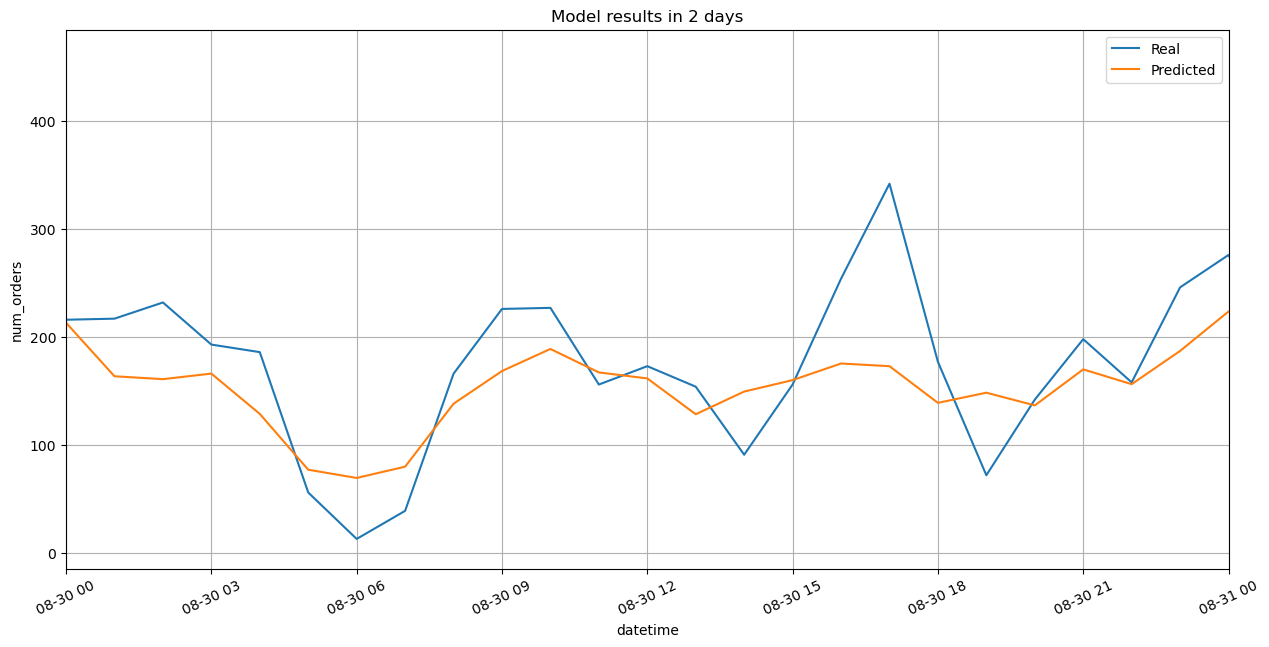

In [26]:
def visual_comparison(lm, x = features_opt_test, y=target_opt_test, x_lim_left='2018-08-30', x_lim_right='2018-08-31'):
    plt.figure(figsize=(15, 7))
    sns.lineplot(x = y.index, y = y, label='Real')
    sns.lineplot(x = y.index, y = lm.predict(x), label='Predicted')
    plt.xticks(rotation=25)
    plt.xlim(pd.to_datetime(x_lim_left),pd.to_datetime(x_lim_right))
    plt.grid()
    plt.title('Model results in 2 days')
visual_comparison(lm)

**Conclusion:**
- we have tested the best model and found out that the result of RMSE metric on the test sample is worse than on the training sample, it means that the model is over-trained
- the result of the LinearRegression model is lower than 48 and equals to 42.63
- built a graph to compare the predicted values with the actual values, the model predicts keeping the trend.

**General conclusion:**
- imported the necessary libraries and modules, loaded the data and performed resampling on an hourly basis
- we analyzed the statistical data and found out that we received on average 84 orders per hour, and the maximum number of orders per hour was 462
- decomposed the data into three components: trend, seasonality and residual and made a graph of the time series and found that we could see an increasing trend, but on this scale it was difficult to evaluate the seasonal component
- we have additionally analyzed the data for the last days of August and came to the conclusion that the amount of orders sharply drops from 12 a.m. to 6 a.m., increases in the morning hours, reaching its morning peak around 9-10 a.m. Further there is some decrease till 2 pm, with the further growth up to the maximum values in 17-18 hours. Further the number of orders is again reduced to 20 hours and starts to grow in the evening hours, reaching a peak around 23:00 - 00:00 hours at night.
- created function for the features: hour, day of week, month, lagging values and moving average
- we divided the data into training and test samples and checked the obtained sample sizes and the correctness of arrangement of time series
- we created a constant model and calculated RMSE for it
- using cross validation, we trained linear regression models, Ridge and Lasso, calculated their RMSE and found out that the results of all models are almost the same and equal to 30.38, the result of Lasso model is slightly worse - 30.39
- by optimizing the lag and moving average we have improved RMSE for all models. LinearRegression (23.589), Ridge (23.598), Lasso (23.64). At this stage the best RMSE value is in LinearRegression model
- we have tested the best model and found out that the result of RMSE on the test sample is worse than on the training sample, it means that the model has been over-trained
- the result of the LinearRegression model is lower than 48 and equals to 42.63
- built a graph to compare the predicted values with the actual values, the model predicts keeping the trend